In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.fft import fftshift
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
import hw3_helper_utils
from scipy.ndimage import convolve

In [2]:
def show_images_grid(images, titles=None):
    num_images = len(images)
    if titles is None:
        titles = [""] * num_images

    num_rows = (num_images + 1) // 2 if num_images > 1 else 1

    fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows * 5))

    if num_images > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx, (img, title) in enumerate(zip(images, titles)):
        ax = axes[idx]
        M, N = img.shape
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    for idx in range(num_images, num_rows * 2):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


def generate_noisy_image(image_path, noise_level=0.02, length=20, angle=30):
    x = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    x = (x - np.min(x)) / (np.max(x) - np.min(x))

    v = noise_level * np.random.randn(*x.shape)

    h = hw3_helper_utils.create_motion_blur_filter(length=length, angle=angle)

    y0 = convolve(x, h, mode="wrap")

    y = y0 + v

    return x, y0, y, h, v


def pad_array(array, shape):
    padded_array = np.zeros(shape)
    start_row = (shape[0] - array.shape[0]) // 2
    start_col = (shape[1] - array.shape[1]) // 2
    padded_array[
        start_row : start_row + array.shape[0], start_col : start_col + array.shape[1]
    ] = array
    return padded_array


def my_best_wiener_filter(
    y: np.ndarray, h: np.ndarray, Sx: np.ndarray, Sv: np.ndarray
) -> np.ndarray:

    h /= np.sum(h)
    H = fft2(h, s=y.shape)
    Y = fft2(y)
    G = np.conj(H) / (np.abs(H) ** 2 + Sv / Sx)
    X_hat = Y * G
    x_hat = np.abs(ifft2(X_hat))
    return x_hat


def my_wiener_filter(y: np.ndarray, h: np.ndarray, K: float) -> np.ndarray:

    h /= np.sum(h)
    H = fft2(h, s=y.shape)
    Y = fft2(y)
    G = np.conj(H) / (np.abs(H) ** 2 + K)
    X_hat = Y * G
    x_hat = np.abs(ifft2(X_hat))
    return x_hat


def my_inverse_filter(y: np.ndarray, h: np.ndarray) -> np.ndarray:

    h /= np.sum(h)
    H = fft2(h, s=y.shape)
    Y = fft2(y)
    X_inv = Y / H
    x_inv = np.abs(ifft2(X_inv))
    return x_inv


def mse(restored, observed):
    return np.mean((np.abs(restored - observed)) ** 2)


def snr(restored, observed):
    signal_power = np.sum(np.abs(restored) ** 2)
    noise_power = np.sum(np.abs(restored - observed) ** 2)
    return signal_power / noise_power


def gradient_descent_optimize_K_SNR(y, h, K_init, lr, max_iters=100, tol=1e-5):

    K = K_init
    history = []

    for _ in range(max_iters):
        x_hat = my_wiener_filter(y, h, K)

        current_snr = snr(fft2(x_hat), fft2(y))
        history.append(current_snr)

        delta_K = 1e-5
        x_hat_plus = my_wiener_filter(y, h, K + delta_K)
        snr_plus = snr(fft2(x_hat_plus), fft2(y))

        K_new = K + lr * (snr_plus - current_snr) / delta_K

        if np.abs(K_new - K) < tol:
            break

        K = K_new

    return K, history


def gradient_descent_optimize_K_MSE(y, h, K_init, lr, max_iters=100, tol=1e-5):

    K = K_init
    history = []

    for _ in range(max_iters):
        x_hat = my_wiener_filter(y, h, K)

        current_mse = mse(x_hat, y)
        history.append(current_mse)

        delta_K = 1e-5
        x_hat_plus = my_wiener_filter(y, h, K + delta_K)
        mse_plus = mse(x_hat_plus, y)

        K_new = K - lr * (mse_plus - current_mse) / delta_K

        if np.abs(K_new - K) < tol:
            break

        K = K_new

    return K, history

In [3]:
image_path = "data/cameraman.tif"
x, y0, y, h, v = generate_noisy_image(
    image_path=image_path, noise_level=0.02, length=20, angle=30
)

x_inv0 = my_inverse_filter(y=y0, h=h)
x_inv = my_inverse_filter(y=y, h=h)

best_x_hat = my_best_wiener_filter(
    y=y, h=h, Sx=np.abs(fft2(x)) ** 2, Sv=np.abs(fft2(v)) ** 2
)

K_init = -1e-2
lr = 1e-3

K_opt_SNR, snr_history = gradient_descent_optimize_K_SNR(y, h, K_init, lr)
K_opt_MSE, mse_history = gradient_descent_optimize_K_MSE(y, h, K_init, lr)

print(f"Optimal K (SNR): {K_opt_SNR} | Optimal K (MSE): {K_opt_MSE}")

x_hat_SNR = my_wiener_filter(y=y, h=h, K=K_opt_SNR)
x_hat_MSE = my_wiener_filter(y=y, h=h, K=K_opt_MSE)

Optimal K (SNR): 1.4575818355084358 | Optimal K (MSE): 258710.07554970018


np.mean(ratio_vx)=3.0541 | np.std(ratio_vx)=108.9472 | np.var(ratio_vx)=11869.4916 | np.max(ratio_vx)=17485.2835 | np.min(ratio_vx)=0.0000
np.mean(ratio_vy)=1.5290 | np.std(ratio_vy)=29.4529 | np.var(ratio_vy)=867.4752 | np.max(ratio_vy)=4888.2548 | np.min(ratio_vy)=0.0000


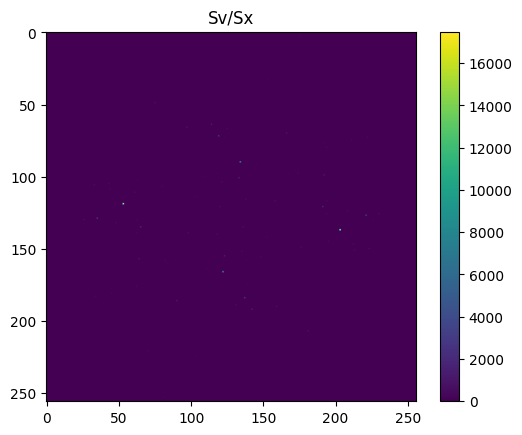

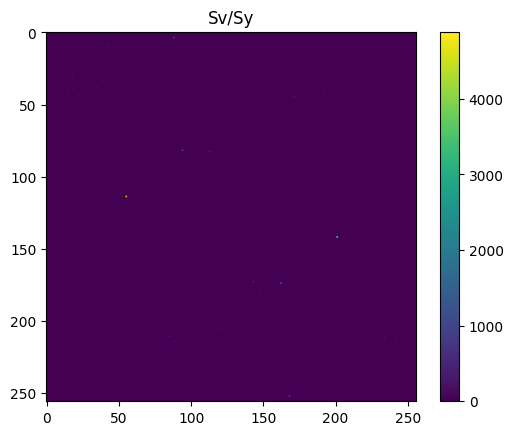

In [4]:
Sx = np.abs(fft2(x)) ** 2
Sv = np.abs(fft2(v)) ** 2
Sy = np.abs(fft2(y)) ** 2

ratio_vx = Sv / Sx
print(
    f"{np.mean(ratio_vx)=:.4f} | {np.std(ratio_vx)=:.4f} | {np.var(ratio_vx)=:.4f} | {np.max(ratio_vx)=:.4f} | {np.min(ratio_vx)=:.4f}"
)
ratio_vy = Sv / Sy
print(
    f"{np.mean(ratio_vy)=:.4f} | {np.std(ratio_vy)=:.4f} | {np.var(ratio_vy)=:.4f} | {np.max(ratio_vy)=:.4f} | {np.min(ratio_vy)=:.4f}"
)
plt.imshow(ratio_vx)
plt.colorbar()
plt.title("Sv/Sx")
plt.show()
plt.imshow(ratio_vy)
plt.colorbar()
plt.title("Sv/Sy")
plt.show()

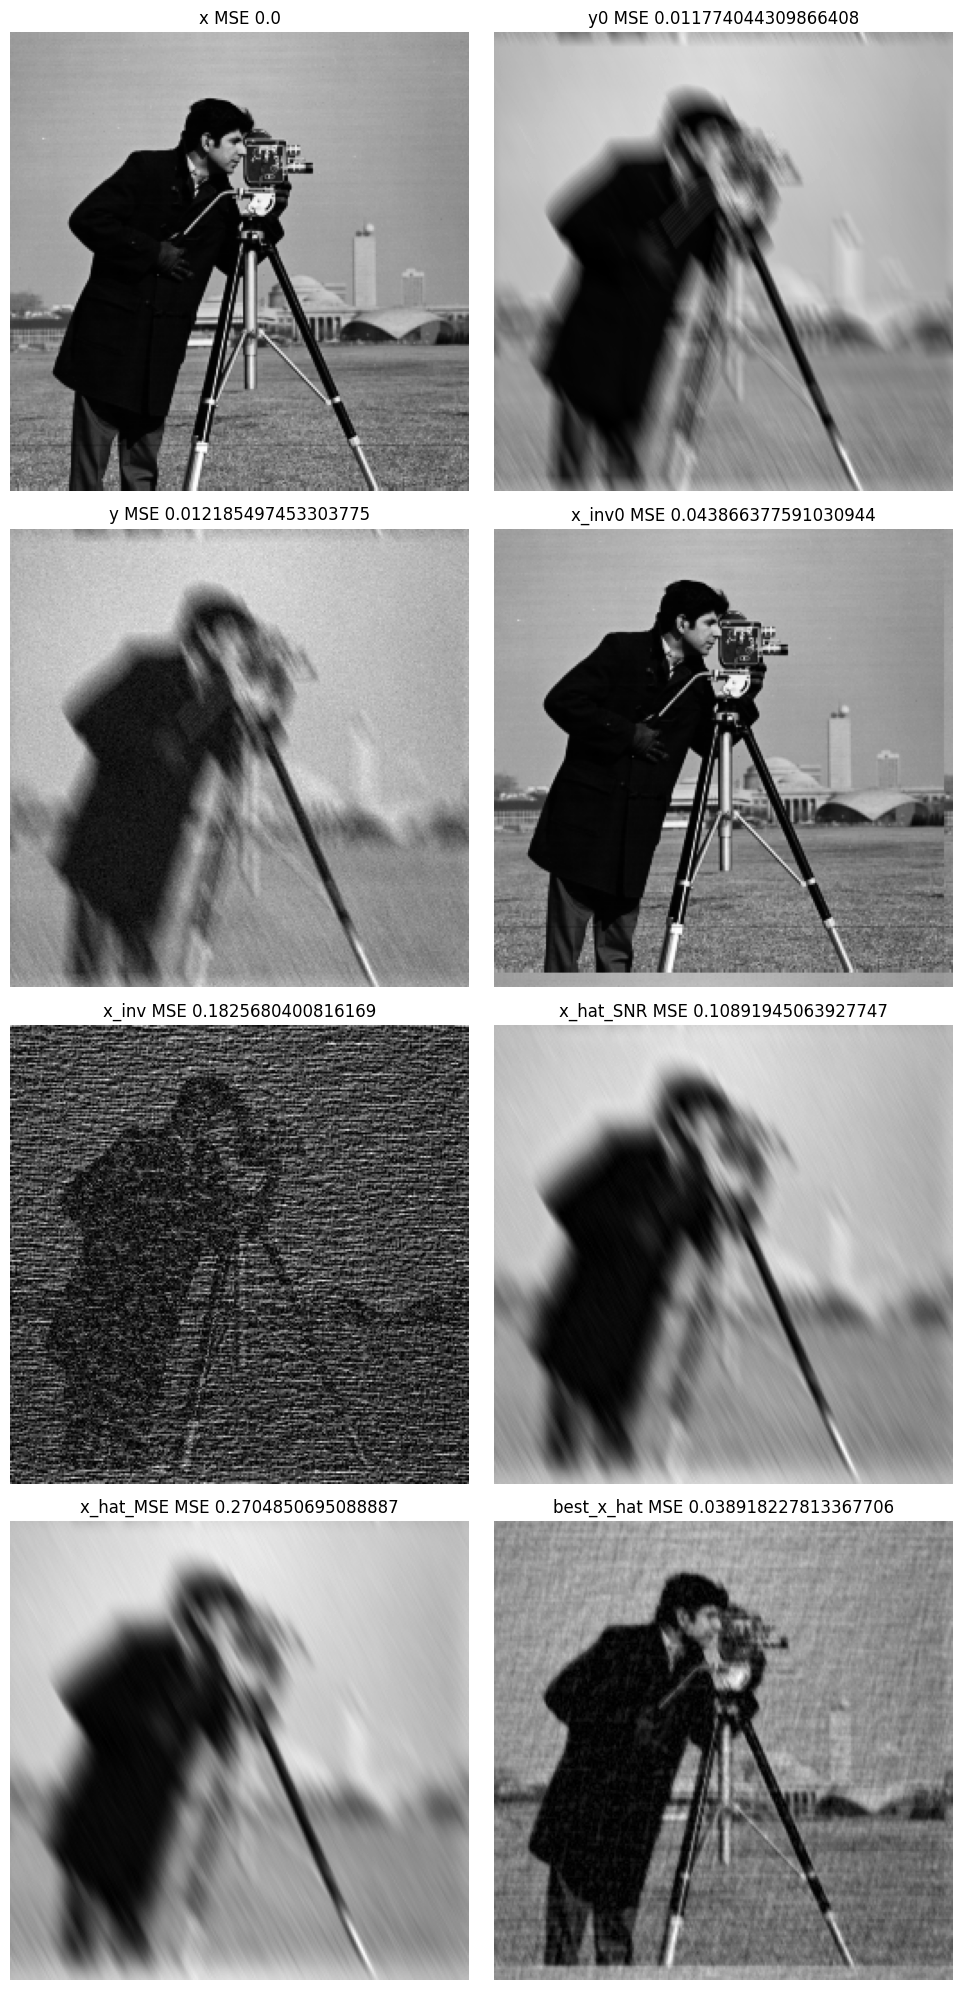

In [5]:
images = [x, y0, y, x_inv0, x_inv, x_hat_SNR, x_hat_MSE, best_x_hat]
titles = [
    f"x MSE {mse(x, x)}",
    f"y0 MSE {mse(y0, x)}",
    f"y MSE {mse(y, x)}",
    f"x_inv0 MSE {mse(x_inv0, x)}",
    f"x_inv MSE {mse(x_inv, x)}",
    f"x_hat_SNR MSE {mse(x_hat_SNR, x)}",
    f"x_hat_MSE MSE {mse(x_hat_MSE, x)}",
    f"best_x_hat MSE {mse(best_x_hat, x)}",
]
show_images_grid(images, titles)

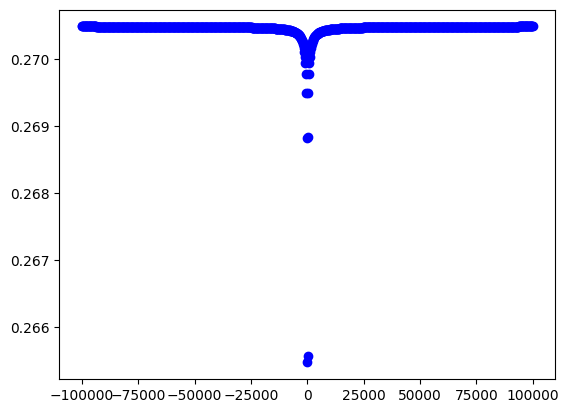

In [7]:
low = -1e5
high = 1e5

Ks = np.linspace(low, high, 1000)
MSEs = np.zeros_like(Ks)
for K in Ks:
    x_hat = my_wiener_filter(y, h, K)
    MSEs[Ks == K] = mse(x_hat, x)
    plt.plot(K, mse(x_hat, x), "bo")